# MMN 13 - Course No 22969 - Amir Noiboar ID 027480110

# Accelerating Inference with KV-Caching

Based On "Build a Large Language Model From Scratch" book by Sebastian Raschka

https://github.com/rasbt/LLMs-from-scratch


## Multi Head Attention with KV-Caching

Herein is the multi-head attention class, with the necessary changes marked by #NEW.

In [1]:
import time
import tiktoken
import torch
import torch.nn as nn


In [2]:
#####################################
# Chapter 3
#####################################
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False, max_seq_len=None, window_size=None):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)

        ####################################################
        # NEW - Registering the cache buffers
        ####################################################
        self.max_seq_len = max_seq_len or context_length
        self.window_size = window_size or self.max_seq_len
        self.register_buffer("cache_k", None, persistent=False)
        self.register_buffer("cache_v", None, persistent=False)
        ####################################################

    def forward(self, x, use_cache=False):
        b, num_tokens, d_in = x.shape

        if use_cache:
            # to prevent self.ptr_cur became negative
            assert num_tokens <= self.window_size, (
                f"Input chunk size ({num_tokens}) exceeds KV cache window size ({self.window_size}). "
            )

        keys_new = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        values_new = self.W_value(x)
        queries = self.W_query(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys_new = keys_new.view(b, num_tokens, self.num_heads, self.head_dim)
        values_new = values_new.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys_new = keys_new.transpose(1, 2)
        values_new = values_new.transpose(1, 2)
        queries = queries.transpose(1, 2)

        ####################################################
        # NEW - create and assign keys and values to cache_k and cache_v
        ####################################################
        if use_cache:
            # Initialize cache_k and cache_v if needed
            if self.cache_k is None or self.cache_k.size(0) != b:
                self.cache_k = torch.zeros(b, self.num_heads,
                                           self.window_size, self.head_dim,
                                           device=x.device)
                self.cache_v = torch.zeros_like(self.cache_k)
                self.ptr_cur = 0  # pointer to next free slot

            # if incoming chunk would overflow discard oldest tokens
            if self.ptr_cur + num_tokens > self.window_size:
                overflow = self.ptr_cur + num_tokens - self.window_size
                # shift everything left by `overflow` (cheap view-copy)
                self.cache_k[:, :, :-overflow, :] = self.cache_k[:, :, overflow:, :].clone()
                self.cache_v[:, :, :-overflow, :] = self.cache_v[:, :, overflow:, :].clone()
                self.ptr_cur -= overflow  # pointer after shift

            # Append the new keys and values to the appropriate cache
            self.cache_k[:, :, self.ptr_cur:self.ptr_cur + num_tokens, :] = keys_new
            self.cache_v[:, :, self.ptr_cur:self.ptr_cur + num_tokens, :] = values_new
            self.ptr_cur += num_tokens

            keys = self.cache_k[:, :, :self.ptr_cur, :]
            values = self.cache_v[:, :, :self.ptr_cur, :]
        else:
            # This is the regular case without KV-Caching
            keys, values = keys_new, values_new
            self.ptr_cur = 0  # keep pointer sane if you interleave modes
        ####################################################
        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        ####################################################
        # NEW - set the causal mask for the cache
        ####################################################
        K = attn_scores.size(-1)

        if num_tokens == K:
            # No cache → use the pre‑baked triangular mask slice
            causal_mask = torch.triu(torch.ones(num_tokens, K, device=x.device, dtype=torch.bool), diagonal=1)
        else:
            # Cached: need to offset the diagonal by (K − num_tokens)
            offset = K - num_tokens  # number of tokens already in cache before this chunk
            row_idx = torch.arange(num_tokens, device=x.device).unsqueeze(1)  # (num_tokens, 1)
            col_idx = torch.arange(K, device=x.device).unsqueeze(0)           # (1, K)
            causal_mask = row_idx + offset < col_idx                          # True where j > i+offset
        ####################################################

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(causal_mask.unsqueeze(0).unsqueeze(0), -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

    ####################################################
    # NEW - reset cache (for generating texts between independent sequences)
    ####################################################
    def reset_cache(self):
        self.cache_k, self.cache_v = None, None
    ####################################################


## Transformer Block and GPT Model with KV-Caching

Herein are the transformer block and GPT model with the necessary changes marked by #NEW.

In [3]:
#####################################
# Chapter 4
#####################################
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"],
            window_size=cfg["kv_window_size"] if "kv_window_size" in cfg else cfg["context_length"]   # NEW
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x, use_cache=False):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)

        # x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        ####################################################
        # NEW - use self attention with the use_cache argument
        ####################################################
        x = self.att(x, use_cache=use_cache)
        ####################################################

        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # self.trf_blocks = nn.Sequential(
        #    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        ####################################################
        # NEW - Allows a manual loop over layers, for passing the additional argument use_cache
        ####################################################
        self.trf_blocks = nn.ModuleList(
            [TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.ptr_current_pos = 0 # counter that remembers how many tokens the model has already cached during an incremental generation session
        ####################################################

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
        self.kv_window_size = cfg["kv_window_size"]  if "kv_window_size" in cfg else cfg["context_length"]

    def forward(self, in_idx, use_cache=False):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        # pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        ####################################################
        # NEW - start at the self.ptr_current_pos and count seq_len steps. Then, bump the counter so the next decoding call continues where we left off
        ####################################################

        if use_cache:
            context_length = self.pos_emb.num_embeddings
            # to prevent generate more sequence than context_length
            # since longer than context_length will cause model out of bound error when reading the position embedding
            assert self.ptr_current_pos + seq_len <= context_length, (
                f"Position embedding overflow. Want to read {self.ptr_current_pos + seq_len} which excceded size of {context_length}"
            )
            pos_ids = torch.arange(self.ptr_current_pos, self.ptr_current_pos + seq_len, device=in_idx.device, dtype=torch.long)
            self.ptr_current_pos += seq_len
        else:
            pos_ids = torch.arange(0, seq_len, device=in_idx.device, dtype=torch.long)
        pos_embeds = self.pos_emb(pos_ids).unsqueeze(0)
        ####################################################

        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)

        # x = self.trf_blocks(x)
        ####################################################
        # NEW - Explicitly transfer the use_cache argument to all transformer blocks
        for blk in self.trf_blocks:
            x = blk(x, use_cache=use_cache)
        ####################################################

        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

    ####################################################
    # NEW - model-level reset to GPTModel to clear all block caches at once
    ####################################################
    def reset_kv_cache(self):
        for blk in self.trf_blocks:
            blk.att.reset_cache()
        self.ptr_current_pos = 0
    ####################################################


## Generating Text

Herein are the text generation functions with the necessary changes marked by #NEW.

Note: Text generation is performed without temperature scaling or top-k sampling to allow comparison of the generated text with and without kv-caching

In [4]:
#####################################
# Chapter 4
#####################################

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


####################################################
# NEW - Generate text with KV-Caching (feed the model only the new token)
####################################################
def generate_text_simple_cached(model, idx, max_new_tokens, context_size=None, use_cache=True):
    model.eval()

    ctx_len = context_size or model.pos_emb.num_embeddings
    kv_window_size = model.kv_window_size

    with torch.no_grad():
        if use_cache:
            model.reset_kv_cache()

            input_tokens = idx[:, -ctx_len:]
            input_tokens_length = input_tokens.size(1)

            # prefill to handle input_tokens_length > kv_window_size
            for i in range(0, input_tokens_length, kv_window_size):
                chunk = input_tokens[:, i:i+kv_window_size]
                logits = model(chunk, use_cache=True)

            # can't generate more than ctx_len of result
            # due to the limitation of position embedding
            max_generable = ctx_len - input_tokens_length
            max_new_tokens = min(max_new_tokens, max_generable)

            for _ in range(max_new_tokens):
                next_idx = logits[:, -1].argmax(dim=-1, keepdim=True)
                idx = torch.cat([idx, next_idx], dim=1)
                logits = model(next_idx, use_cache=True) # feed the model only the new token
        else:
            for _ in range(max_new_tokens):
                logits = model(idx[:, -ctx_len:], use_cache=False)
                next_idx = logits[:, -1].argmax(dim=-1, keepdim=True)
                idx = torch.cat([idx, next_idx], dim=1)

    return idx


## Using Open-AI pre-trained parameters

### download and load GPT params

In [5]:
import os
import json

import numpy as np
import requests
import tensorflow as tf
from tqdm import tqdm

def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    backup_base_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        backup_url = os.path.join(backup_base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path, backup_url)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        response = requests.get(download_url, stream=True, timeout=60)
        response.raise_for_status()

        file_size = int(response.headers.get("Content-Length", 0))

        # Check if file exists and has same size
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size and file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return True

        block_size = 1024  # 1 KB
        desc = os.path.basename(download_url)
        with tqdm(total=file_size, unit="iB", unit_scale=True, desc=desc) as progress_bar:
            with open(destination, "wb") as file:
                for chunk in response.iter_content(chunk_size=block_size):
                    if chunk:
                        file.write(chunk)
                        progress_bar.update(len(chunk))
        return True

    try:
        if _attempt_download(url):
            return
    except requests.exceptions.RequestException:
        if backup_url is not None:
            print(f"Primary URL ({url}) failed. Attempting backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except requests.exceptions.RequestException:
                pass

        error_message = (
            f"Failed to download from both primary URL ({url})"
            f"{' and backup URL (' + backup_url + ')' if backup_url else ''}."
            "\nCheck your internet connection or the file availability.\n"
            "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273"
        )
        print(error_message)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

C:\Users\Amir Noiboar\LLMs-from-scratch\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### Assign the OpenAI weights to the corresponding weight tensors in our GPTModel instance


In [6]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



## Benchmarking text generation with KV-Caching vs. without

In [7]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import tiktoken

# ============================================================
# Tunable experiment parameters
# ============================================================

NUM_RUNS = 7         # statistical stability
WARMUP_RUNS = 2       # GPU warm-up
MAX_NEW_TOKENS = 128  # decode length
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Representative context lengths
LENGTHS = [128, 256, 512, 768]


# ============================================================
# Timing helpers
# ============================================================

def _sync():
    if DEVICE.type == "cuda":
        torch.cuda.synchronize()

def _now():
    return time.perf_counter()

def make_exact_length_input(tokenizer, seq_len):
    """Create prompt with EXACT token length."""
    tokens = [tokenizer.eot_token] * seq_len
    return torch.tensor(tokens, device=DEVICE).unsqueeze(0)

# ============================================================
# Single measurement (prefill / decode / combined)
# ============================================================

def measure_one(model, tokenizer, seq_len, use_cache):
    """
    Returns:
        prefill_time_sec
        decode_tokens_per_sec
        combined_tokens_per_sec
    """

    idx = make_exact_length_input(tokenizer, seq_len)

    # Respect positional embedding limit
    max_ctx = model.pos_emb.num_embeddings
    gen_tokens = min(MAX_NEW_TOKENS, max_ctx - seq_len)

    with torch.no_grad():

        # ---------------- PREFILL ----------------
        if use_cache:
            model.reset_kv_cache()

        _sync()
        t0 = _now()

        _ = model(idx, use_cache=use_cache)

        _sync()
        prefill_time = _now() - t0

        # ---------------- DECODE ----------------
        _sync()
        t1 = _now()

        if gen_tokens > 0:
            if use_cache:
                cur = idx[:, -1:]
                for _ in range(gen_tokens):
                    logits = model(cur, use_cache=True)
                    cur = logits[:, -1].argmax(dim=-1, keepdim=True)
            else:
                cur = idx.clone()
                for _ in range(gen_tokens):
                    logits = model(cur, use_cache=False)
                    next_tok = logits[:, -1].argmax(dim=-1, keepdim=True)
                    cur = torch.cat([cur, next_tok], dim=1)

        _sync()
        decode_time = _now() - t1 if gen_tokens > 0 else 1e-12

    # ---------------- METRICS ----------------
    decode_tok_per_sec = gen_tokens / decode_time if gen_tokens > 0 else 0.0
    combined_tok_per_sec = gen_tokens / (prefill_time + decode_time) if gen_tokens > 0 else 0.0

    return prefill_time, decode_tok_per_sec, combined_tok_per_sec

# ============================================================
# Aggregate statistics (median + best/worst)
# ============================================================

def aggregate(model, tokenizer, seq_len, use_cache):

    # Warm-up runs
    for _ in range(WARMUP_RUNS):
        measure_one(model, tokenizer, seq_len, use_cache)

    results = np.array([
        measure_one(model, tokenizer, seq_len, use_cache)
        for _ in range(NUM_RUNS)
    ])

    median = np.median(results, axis=0)

    # Best / worst by combined throughput
    best = results[np.argmax(results[:, 2])]
    worst = results[np.argmin(results[:, 2])]

    return median, best, worst

# ============================================================
# Run full experiment
# ============================================================

def run_experiment(model):

    tokenizer = tiktoken.get_encoding("gpt2")

    reg = {k: [] for k in ["prefill", "decode", "comb"]}
    kv  = {k: [] for k in ["prefill", "decode", "comb"]}

    for L in LENGTHS:
        print(f"\nLength {L}")

        r_med, r_best, r_worst = aggregate(model, tokenizer, L, use_cache=False)
        k_med, k_best, k_worst = aggregate(model, tokenizer, L, use_cache=True)

        rp, rd, rc = r_med
        kp, kd, kc = k_med

        reg["prefill"].append(rp)
        reg["decode"].append(rd)
        reg["comb"].append(rc)

        kv["prefill"].append(kp)
        kv["decode"].append(kd)
        kv["comb"].append(kc)

        print(f" Regular (median) → prefill {rp:.3f}s | decode {rd:.1f} tok/s | combined {rc:.1f} tok/s")
        print(f" KV-cache (median) → prefill {kp:.3f}s | decode {kd:.1f} tok/s | combined {kc:.1f} tok/s")

        print(f"   Regular best/worst combined: {r_best[2]:.1f} / {r_worst[2]:.1f} tok/s")
        print(f"   KV best/worst combined:      {k_best[2]:.1f} / {k_worst[2]:.1f} tok/s")

    return reg, kv

# ============================================================
# Plotting
# ============================================================

def plot_all(reg, kv):

    fig, axs = plt.subplots(1, 4, figsize=(18, 4))

    # Prefill time
    axs[0].plot(LENGTHS, reg["prefill"], "o-", label="Regular")
    axs[0].plot(LENGTHS, kv["prefill"], "o-", label="KV-cache")
    axs[0].set_title("Prefill Time")
    axs[0].set_ylabel("Seconds")
    axs[0].grid(True)
    axs[0].legend()

    # Decode speed
    axs[1].plot(LENGTHS, reg["decode"], "o-", label="Regular")
    axs[1].plot(LENGTHS, kv["decode"], "o-", label="KV-cache")
    axs[1].set_title("Decode Speed")
    axs[1].set_ylabel("Tokens/sec")
    axs[1].grid(True)
    axs[1].legend()

    # Combined throughput
    axs[2].plot(LENGTHS, reg["comb"], "o-", label="Regular")
    axs[2].plot(LENGTHS, kv["comb"], "o-", label="KV-cache")
    axs[2].set_title("Combined Throughput")
    axs[2].set_ylabel("Tokens/sec")
    axs[2].grid(True)
    axs[2].legend()

    # Speedup ratio
    speedup_decode = np.array(kv["decode"]) / np.array(reg["decode"])
    speedup_comb   = np.array(kv["comb"]) / np.array(reg["comb"])

    axs[3].plot(LENGTHS, speedup_decode, "o-", label="Decode speedup")
    axs[3].plot(LENGTHS, speedup_comb, "o--", label="Combined speedup")
    axs[3].set_title("KV-Cache Speedup Ratio")
    axs[3].set_ylabel("× faster than regular")
    axs[3].grid(True)
    axs[3].legend()

    for ax in axs:
        ax.set_xlabel("Input length (tokens)")

    plt.tight_layout()
    plt.show()

# ============================================================
# Entry point
# ============================================================

def benchmark_and_plot(model):

    model.eval()
    model.to(DEVICE)

    print("\n=== MODEL INFO ===")
    print("Device:", DEVICE)
    print("Context length:", model.pos_emb.num_embeddings)
    print("KV window size:", model.kv_window_size)
    print("===================\n")

    reg, kv = run_experiment(model)
    # plot_all(reg, kv)

    return reg, kv


## Run benchmark with small-medium-large models


Loading: gpt2-small (124M)
File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe
Model on: cuda
Context length: 1024
KV window size: 1024
--------------------------------------------------------------------------------
Identical test (greedy decoding):
  Prompt="Hello, I am..."  Identical: True
  Prompt="The quick brown fox jumps over the lazy ..."  Identical: True
  Prompt="In a surprising research result, the aut..."  Identical: True
--------------------------------------------------------------------------------
Benchmarking...

=== MODEL INFO ===
Device: cuda
Context length: 1024
KV windo

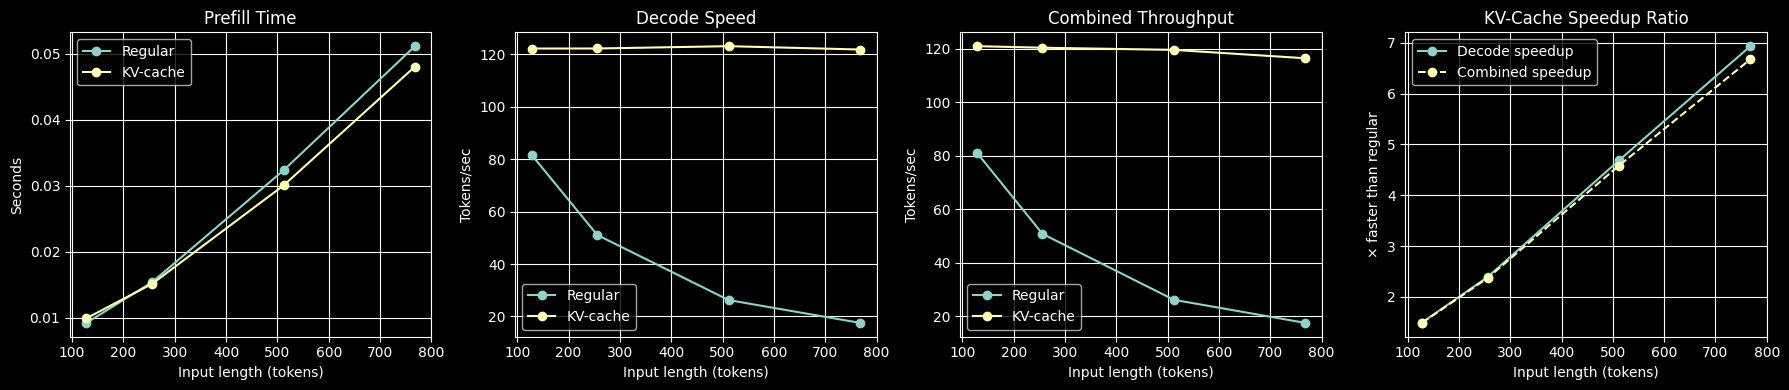


Loading: gpt2-medium (355M)
File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe
Model on: cuda
Context length: 1024
KV window size: 1024
--------------------------------------------------------------------------------
Identical test (greedy decoding):
  Prompt="Hello, I am..."  Identical: True
  Prompt="The quick brown fox jumps over the lazy ..."  Identical: True
  Prompt="In a surprising research result, the aut..."  Identical: True
--------------------------------------------------------------------------------
Benchmarking...

=== MODEL INFO ===
Device: cuda
Context length: 1024
KV wind

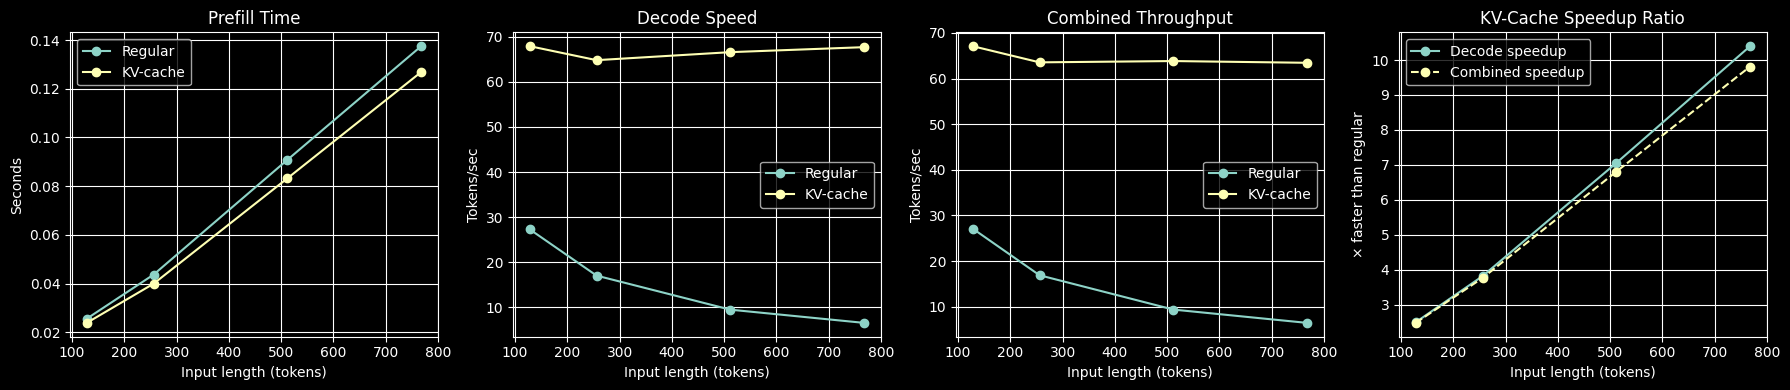


Loading: gpt2-large (774M)
File already exists and is up-to-date: gpt2\774M\checkpoint
File already exists and is up-to-date: gpt2\774M\encoder.json
File already exists and is up-to-date: gpt2\774M\hparams.json
File already exists and is up-to-date: gpt2\774M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\774M\model.ckpt.index
File already exists and is up-to-date: gpt2\774M\model.ckpt.meta
File already exists and is up-to-date: gpt2\774M\vocab.bpe
Model on: cuda
Context length: 1024
KV window size: 1024
--------------------------------------------------------------------------------
Identical test (greedy decoding):
  Prompt="Hello, I am..."  Identical: True
  Prompt="The quick brown fox jumps over the lazy ..."  Identical: True
  Prompt="In a surprising research result, the aut..."  Identical: True
--------------------------------------------------------------------------------
Benchmarking...

=== MODEL INFO ===
Device: cuda
Context length: 1024
KV windo

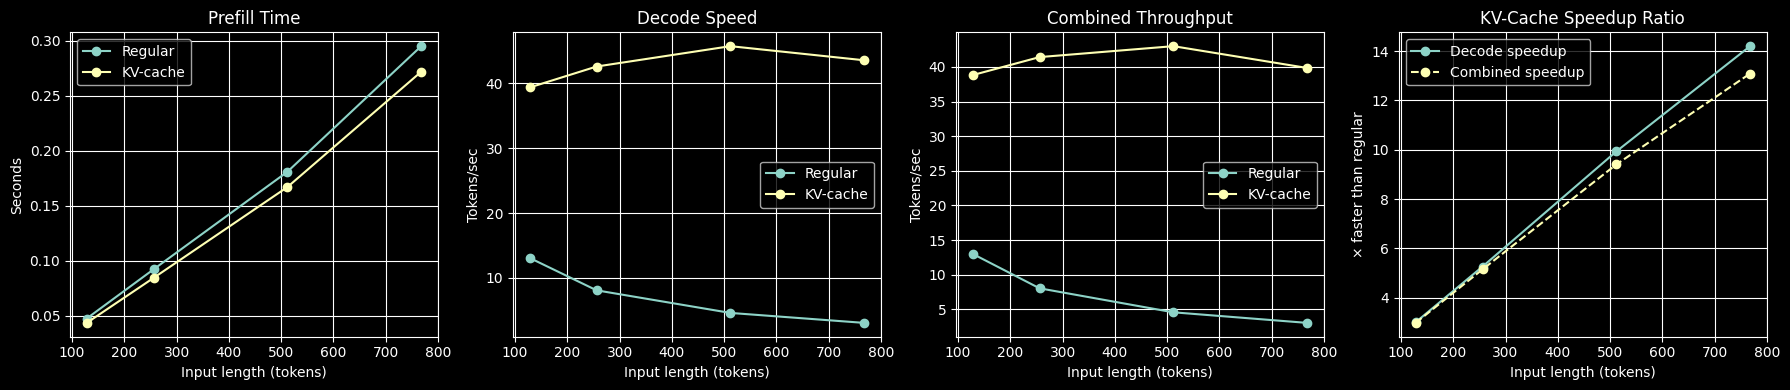


Done. Models tested: ['gpt2-small (124M)', 'gpt2-medium (355M)', 'gpt2-large (774M)']


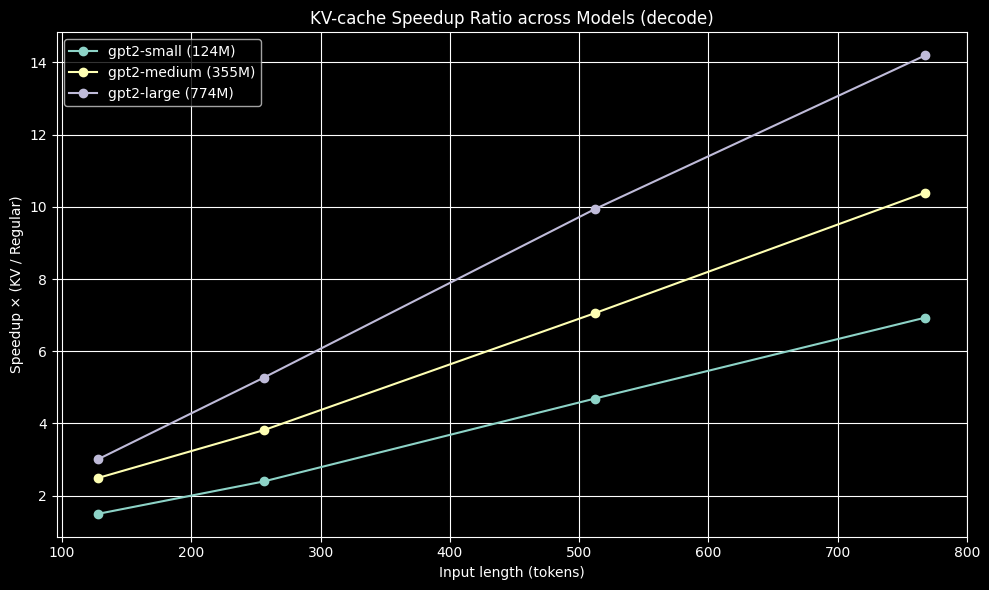

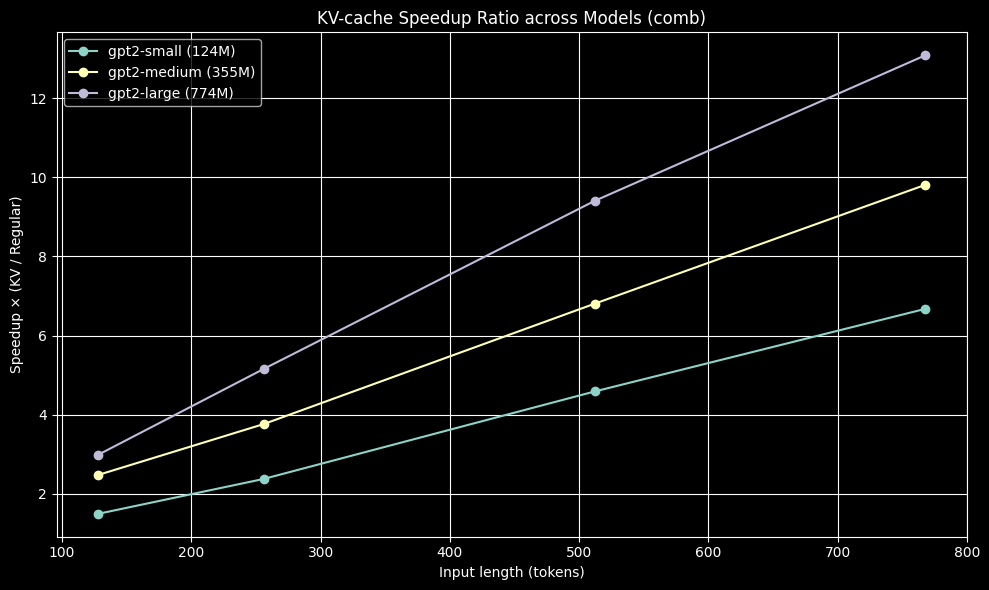

In [8]:
import torch
import tiktoken
import numpy as np
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# Base + model configs
# --------------------------
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
}

model_configs = {
    "gpt2-small (124M)":  {"emb_dim": 768,  "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)":  {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)":    {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# --------------------------
# Utilities
# --------------------------
tokenizer = tiktoken.get_encoding("gpt2")

def build_cfg(model_name: str):
    cfg = dict(BASE_CONFIG)                 # fresh copy each time (prevents drift)
    cfg.update(model_configs[model_name])   # add model-specific sizes
    cfg["kv_window_size"] = cfg["context_length"]  # KV cache window = context (your design)
    return cfg

def load_pretrained_gpt2(model_name: str, models_dir="gpt2"):
    cfg = build_cfg(model_name)

    # model_size string expected by your loader: "124M", "355M", "774M", ...
    model_size = model_name.split(" ")[-1].lstrip("(").rstrip(")")

    settings, params = download_and_load_gpt2(model_size=model_size, models_dir=models_dir)

    model = GPTModel(cfg)
    load_weights_into_gpt(model, params)
    model.eval()
    model.to(DEVICE)

    return model, cfg

def identical_test(model, prompts, n_new=50):
    ctx = model.pos_emb.num_embeddings
    all_ok = True
    for p in prompts:
        idx = torch.tensor(tokenizer.encode(p), device=DEVICE).unsqueeze(0)
        out_regular = generate_text_simple(model, idx.clone(), n_new, ctx)
        out_cached  = generate_text_simple_cached(model, idx.clone(), n_new)
        ok = torch.equal(out_regular, out_cached)
        print(f'  Prompt="{p[:40]}..."  Identical: {ok}')
        all_ok = all_ok and ok
    return all_ok

# --------------------------
# Run all models
# --------------------------
MODELS_TO_RUN = [
    "gpt2-small (124M)",
    "gpt2-medium (355M)",
    "gpt2-large (774M)",
]

PROMPTS = [
    "Hello, I am",
    "The quick brown fox jumps over the lazy dog.",
    "In a surprising research result, the authors found that",
]

results_by_model = {}  # model_name -> {"reg":..., "kv":..., "cfg":..., "identical": bool}

for model_name in MODELS_TO_RUN:
    print("\n" + "="*80)
    print("Loading:", model_name)
    print("="*80)

    model, cfg = load_pretrained_gpt2(model_name, models_dir="gpt2")

    print("Model on:", DEVICE)
    print("Context length:", model.pos_emb.num_embeddings)
    print("KV window size:", getattr(model, "kv_window_size", None))
    print("-"*80)

    print("Identical test (greedy decoding):")
    identical_ok = identical_test(model, PROMPTS, n_new=50)

    print("-"*80)
    print("Benchmarking...")
    reg, kv = benchmark_and_plot(model)   # return reg, kv
    plot_all(reg, kv)

    results_by_model[model_name] = {
        "reg": reg,
        "kv": kv,
        "cfg": cfg,
        "identical": identical_ok,
    }

print("\nDone. Models tested:", list(results_by_model.keys()))

# --------------------------
# Combined plot: speedup curves across models
# --------------------------
def safe_div(a, b, eps=1e-12):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    return a / (b + eps)

def plot_speedup_across_models(results_by_model, which="comb"):
    """
    which: "decode" or "comb"
    """
    plt.figure(figsize=(10, 6))
    for model_name, d in results_by_model.items():
        reg = d["reg"][which]
        kv  = d["kv"][which]
        speedup = safe_div(kv, reg)
        plt.plot(LENGTHS, speedup, "o-", label=f"{model_name}")

    plt.title(f"KV-cache Speedup Ratio across Models ({which})")
    plt.xlabel("Input length (tokens)")
    plt.ylabel("Speedup × (KV / Regular)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_speedup_across_models(results_by_model, which="decode")
plot_speedup_across_models(results_by_model, which="comb")
